# Akbank Derin Öğrenme Bootcamp: Kelebek Türü Sınıflandırma Projesi

Bu proje, Akbank Derin Öğrenme Bootcamp'i kapsamında geliştirilmiştir. Projenin amacı, verilen görsellerdeki kelebek ve güve türlerini evrişimli sinir ağları (CNN) kullanarak sınıflandıran bir model oluşturmaktır.

## 1. Proje Kurulumu ve Veri Yükleme

Bu ilk adımda, projenin temelini oluşturan işlemler gerçekleştirilmektedir:
* Gerekli kütüphaneler (TensorFlow, Pandas, Matplotlib vb.) import edilir.
* Projenin her çalıştırmada aynı sonuçları vermesi için `SEED` değerleri sabitlenerek tekrarlanabilirlik sağlanır.
* Eğer uyumlu bir GPU varsa, daha hızlı eğitim için `mixed_precision` politikası aktif edilir.
* Kaggle üzerindeki veri setinin yolu belirtilir ve `butterflies and moths.csv` dosyası bir Pandas DataFrame'e yüklenir.

In [1]:
# === Kurulum & Importlar & Seed ===
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Tekrarlanabilirlik
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# (İsteğe bağlı) Mixed Precision - GPU varsa hız kazandırır
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision aktif.")
except Exception as e:
    print("Mixed precision geçildi:", e)

# Yol ve CSV
DATA_DIR = "/kaggle/input/butterfly-images40-species"
CSV_PATH = f"{DATA_DIR}/butterflies and moths.csv"

df = pd.read_csv(CSV_PATH)
print("Veri setinin ilk 5 satırı:")
display(df.head())

# Genel ayarlar
plt.rcParams["figure.dpi"] = 120
sns.set(style="whitegrid")


2025-09-26 13:56:20.772666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758894980.945645      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758894981.001361      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Mixed precision aktif.
Veri setinin ilk 5 satırı:


class id             filepaths  labels data set
0         0  train/ADONIS/001.jpg  ADONIS    train
1         0  train/ADONIS/002.jpg  ADONIS    train
2         0  train/ADONIS/003.jpg  ADONIS    train
3         0  train/ADONIS/004.jpg  ADONIS    train
4         0  train/ADONIS/005.jpg  ADONIS    train

## 2. Keşifsel Veri Analizi (Exploratory Data Analysis - EDA)

Model oluşturma aşamasına geçmeden önce veri setini anlamak çok önemlidir. Bu bölümde aşağıdaki analizler yapılmaktadır:
* Veri setindeki toplam eşsiz kelebek türü sayısı hesaplanır.
* Verinin `train`, `valid` ve `test` olarak nasıl ayrıldığı bir bar grafiği ile görselleştirilir.
* Eğitim setinden rastgele 9 örnek seçilerek görselleri ve etiketleri gösterilir. Bu, veri setinin içeriği hakkında görsel bir fikir edinmemizi sağlar.

Toplam eşsiz kelebek türü sayısı: 100



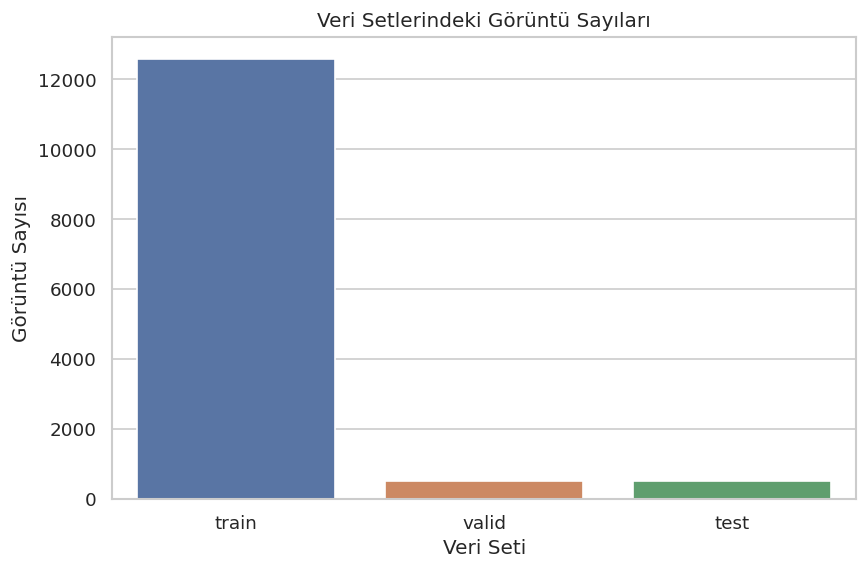

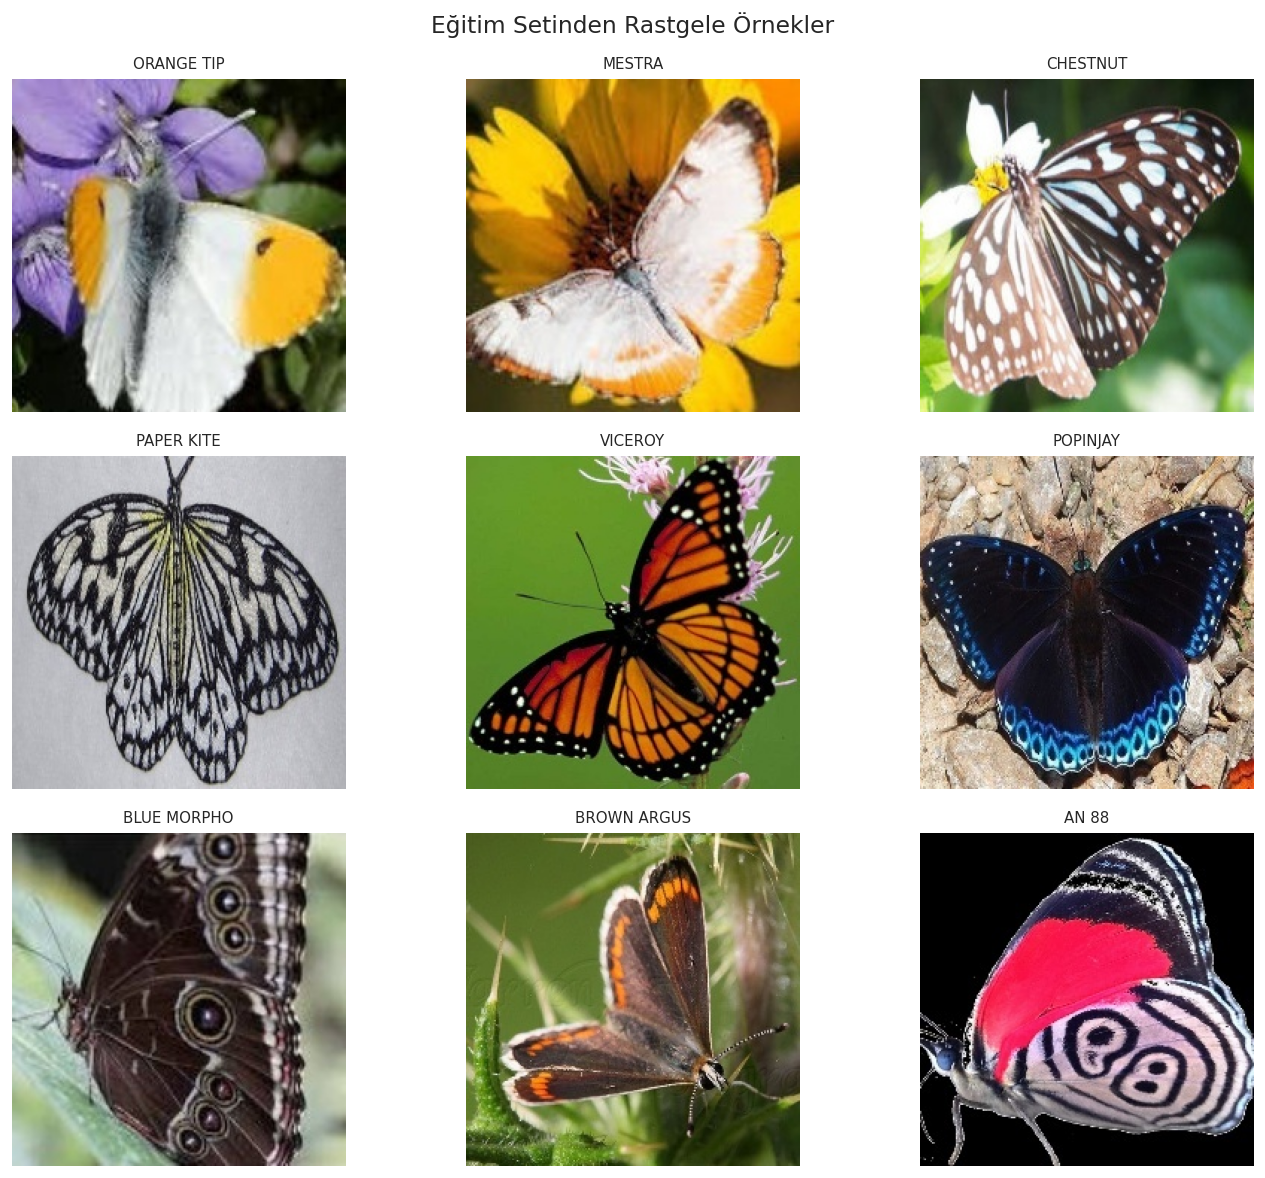

In [2]:
# Eşsiz etiket sayısı
unique_labels_count = df['labels'].nunique()
print(f"Toplam eşsiz kelebek türü sayısı: {unique_labels_count}\n")

# Split dağılımı
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='data set', order=['train','valid','test'])
plt.title('Veri Setlerindeki Görüntü Sayıları')
plt.xlabel('Veri Seti'); plt.ylabel('Görüntü Sayısı')
plt.show()

# Eğitim setinden 3x3 örnek
train_df = df[df['data set'] == 'train'].copy()
sample_grid = train_df.sample(n=9, random_state=SEED)

plt.figure(figsize=(12,10))
for i, row in enumerate(sample_grid.itertuples(), 1):
    img_path = os.path.join(DATA_DIR, row.filepaths)
    img = plt.imread(img_path)
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title(row.labels, fontsize=9)
    plt.axis('off')
plt.suptitle('Eğitim Setinden Rastgele Örnekler', fontsize=14)
plt.tight_layout()
plt.show()


## 3. Veri Ön İşleme ve Görüntü Çoğaltma (Data Augmentation)

Bu bölümde, görüntüler modele beslenmeye hazır hale getirilir. `ImageDataGenerator` sınıfı kullanılarak güçlü bir veri işleme akışı oluşturulur:
* Görüntülerin yeniden boyutlandırılacağı `IMG_WIDTH` ve `IMG_HEIGHT` gibi temel parametreler tanımlanır.
* **Eğitim (Train) Seti için:** Modelin ezberlemesini (overfitting) önlemek ve genelleme yeteneğini artırmak için **veri çoğaltma (augmentation)** uygulanır. Görüntülere rastgele döndürme, kaydırma, kırpma ve yakınlaştırma gibi işlemler yapılır.
* **Doğrulama (Validation) ve Test Setleri için:** Bu setlerde sadece piksel değerleri `1./255` ile ölçeklenerek [0, 1] aralığına getirilir. Bu setlere augmentation uygulanmaz çünkü modelin gerçek dünya performansını doğru bir şekilde ölçmemiz gerekir.
* **Sınıf Dengesizliği (Class Imbalance):** Eğitim setindeki sınıf dağılımı dengesiz olabileceğinden, azınlık sınıflara daha fazla önem verilmesi için `class_weight` hesaplanır.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

# Görüntü boyutu ve batch
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Ayrık veri çerçeveleri
train_df = df[df['data set'] == 'train'].copy()
valid_df = df[df['data set'] == 'valid'].copy()
test_df  = df[df['data set'] == 'test' ].copy()

# Augmentation (train)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.15,
    zoom_range=0.20,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Valid/Test: sadece ölçekleme
valtest_datagen = ImageDataGenerator(rescale=1./255)

# Generator'lar
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=DATA_DIR,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

validation_generator = valtest_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=DATA_DIR,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = valtest_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=DATA_DIR,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Sınıf ağırlıkları (imbalance için)
label_counts = Counter(train_df['labels'])
total = sum(label_counts.values())
num_classes = len(label_counts)

class_weight_dict = {
    idx: total / (num_classes * label_counts[label])
    for label, idx in train_generator.class_indices.items()
}

print("Sınıf ağırlıkları (ilk 10):", dict(list(class_weight_dict.items())[:10]))


Found 12594 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Sınıf ağırlıkları (ilk 10): {0: 0.9995238095238095, 1: 1.1770093457943924, 2: 1.1994285714285715, 3: 1.0408264462809917, 4: 0.98390625, 5: 0.8995714285714286, 6: 0.8806993006993007, 7: 0.9762790697674418, 8: 0.9060431654676259, 9: 1.0672881355932204}


## 4. Model Mimarisi - Baseline CNN (v1)

Projenin ilk modeli olarak temel bir Evrişimli Sinir Ağı (CNN) oluşturulur. Bu model, daha sonra geliştirilecek olan `model_v2` için bir temel (baseline) teşkil edecektir.
* Model, `Conv2D` ve `MaxPooling2D` katmanlarından oluşan üç ana bloktan oluşur. Bu bloklar, görüntülerdeki hiyerarşik özellikleri (kenarlar, dokular, şekiller) çıkarmak için kullanılır.
* Özellik haritaları `Flatten` katmanı ile tek boyutlu bir vektöre dönüştürülür.
* `Dense` katmanları, çıkarılan özelliklerden sınıflar arası ilişkileri öğrenir.
* Ezberlemeyi azaltmak için `Dropout` katmanı eklenmiştir.
* Çıkış katmanı, `unique_labels_count` (toplam tür sayısı) kadar nöron içerir ve `softmax` aktivasyon fonksiyonu ile her bir sınıf için bir olasılık değeri üretir.

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="input")

x = Conv2D(32, (3,3), activation='relu', padding='same', name="conv1")(inputs)
x = MaxPooling2D(pool_size=(2,2), name="pool1")(x)

x = Conv2D(64, (3,3), activation='relu', padding='same', name="conv2")(x)
x = MaxPooling2D(pool_size=(2,2), name="pool2")(x)

x = Conv2D(128, (3,3), activation='relu', padding='same', name="conv3")(x)
x = MaxPooling2D(pool_size=(2,2), name="pool3")(x)

x = Flatten(name="flatten")(x)
x = Dense(512, activation='relu', name="fc1")(x)
x = Dropout(0.5, name="drop1")(x)

# Mixed precision açıksa çıkışları float32'ye zorlamak uyarıları azaltır
outputs = Dense(unique_labels_count, activation='softmax', dtype='float32', name="pred")(x)

model = Model(inputs=inputs, outputs=outputs, name="butterfly_cnn")

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1758895029.206466      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "butterfly_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,525,284 (196.55 MB)

 Trainable params: 51,525,284 (196.55 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Callback'lerin Tanımlanması

Callback'ler, model eğitim sürecini izlemek ve kontrol etmek için kullanılan güçlü araçlardır. Bu projede üç temel callback tanımlanmıştır:
* **`EarlyStopping`**: Modelin doğrulama seti (validation) üzerindeki kaybı (`val_loss`) belirli bir `patience` (sabır) süresi boyunca iyileşmediğinde eğitimi otomatik olarak durdurur. Bu, gereksiz hesaplama maliyetini önler ve en iyi modelin kaçırılmamasını sağlar.
* **`ReduceLROnPlateau`**: `val_loss`'ta bir durgunluk (plato) tespit edildiğinde, öğrenme oranını (learning rate) dinamik olarak düşürür. Bu, modelin minimum noktaya daha hassas bir şekilde yakınsamasına yardımcı olur.
* **`ModelCheckpoint`**: Eğitim boyunca sadece en iyi (`val_loss` değeri en düşük olan) modelin ağırlıklarını bir dosyaya kaydeder.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

CKPT_PATH = "butterfly_best.keras"  # TF 2.15+ için önerilen uzantı

callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(CKPT_PATH, monitor="val_loss", save_best_only=True, verbose=1)
]

print("Callback'ler hazır.")


Callback'ler hazır.


## 6. Baseline Modelin (v1) Eğitilmesi

Bu hücrede, daha önce tanımlanan `model`, `train_generator`, `validation_generator` ve `callbacks` kullanılarak eğitim süreci başlatılır.
* `epochs=30` olarak belirlenmiş olsa da, `EarlyStopping` callback'i sayesinde model daha erken durabilir.
* Hesaplanan `class_weight` parametresi, eğitim sırasında sınıf dengesizliğinin etkisini azaltmak için kullanılır.
* Eğitim süreci boyunca elde edilen metrikler (accuracy, loss, val_accuracy, val_loss) `history` nesnesinde saklanır.

In [6]:

epochs = 30  # EarlyStopping var; 30 güvenli
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1758895034.763215      63 service.cc:148] XLA service 0x78a630003780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758895034.764248      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758895035.141638      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/394 ━━━━━━━━━━━━━━━━━━━━ 1:00:18 9s/step - accuracy: 0.0000e+00 - loss: 4.7471

I0000 00:00:1758895040.903217      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.0371 - loss: 4.3985
Epoch 1: val_loss improved from inf to 2.97691, saving model to butterfly_best.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 214s 522ms/step - accuracy: 0.0372 - loss: 4.3977 - val_accuracy: 0.2500 - val_loss: 2.9769 - learning_rate: 0.0010
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.1754 - loss: 3.3264
Epoch 2: val_loss improved from 2.97691 to 2.26200, saving model to butterfly_best.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 143s 362ms/step - accuracy: 0.1755 - loss: 3.3260 - val_accuracy: 0.4160 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.3001 - loss: 2.7089
Epoch 3: val_loss improved from 2.26200 to 1.78150, saving model to butterfly_best.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 141s 357ms/step - accuracy: 0.3002 - loss: 2.7087 - val_accuracy: 0.5220 - val_loss: 1.7815 - learning_rate: 0.0010
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/

## 7. Öğrenme Eğrilerinin Görselleştirilmesi (v1)

Eğitim sürecinin nasıl ilerlediğini anlamak için en iyi yöntemlerden biri öğrenme eğrilerini (learning curves) çizmektir.
* Bu hücredeki fonksiyon, `history` nesnesini kullanarak eğitim ve doğrulama setleri için **Accuracy** ve **Loss** değerlerinin her bir epoch'ta nasıl değiştiğini gösteren grafikleri çizer.
* Bu grafikler, modelin **overfitting** (ezberleme) veya **underfitting** (yetersiz öğrenme) eğiliminde olup olmadığını analiz etmek için kritik öneme sahiptir.

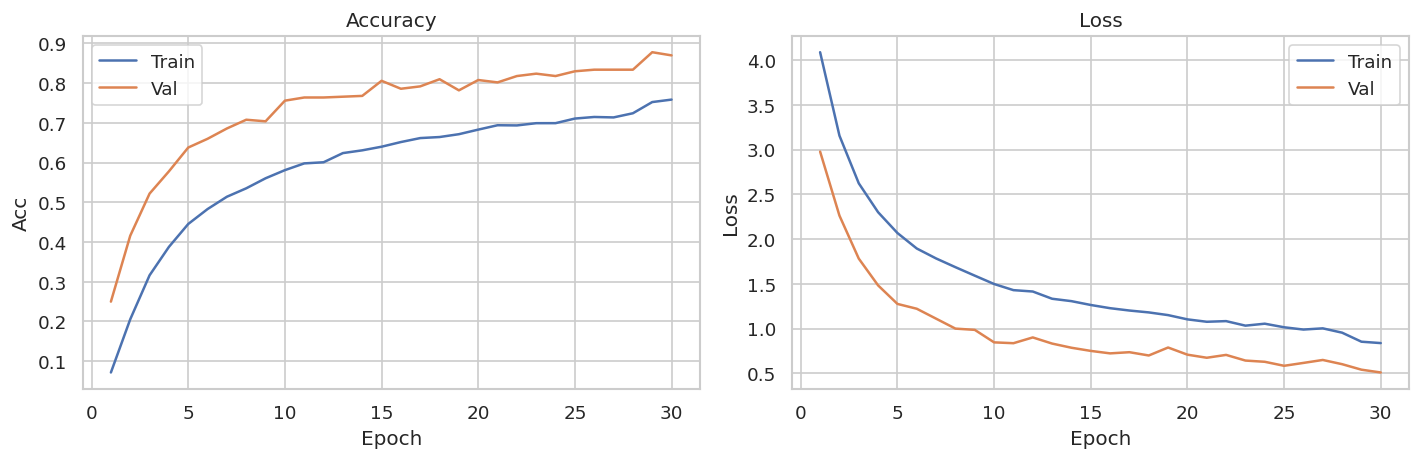

Eğri görselleri kaydedildi: learning_curves.png


In [7]:
def plot_history(h, save_path="learning_curves.png"):
    acc = h.history.get('accuracy', [])
    val_acc = h.history.get('val_accuracy', [])
    loss = h.history.get('loss', [])
    val_loss = h.history.get('val_loss', [])
    ep = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(ep, acc, label='Train'); plt.plot(ep, val_acc, label='Val')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(ep, loss, label='Train'); plt.plot(ep, val_loss, label='Val')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Eğri görselleri kaydedildi: {save_path}")

plot_history(history)


## 8. Hiperparametre Optimizasyonu: Daha Derin Model (v2)

İlk modelden elde edilen sonuçları iyileştirmek amacıyla yeni bir model (`model_v2`) tasarlanır. Bu, manuel bir hiperparametre optimizasyonu denemesidir.
* **Daha Derin Mimari:** Modele 256 filtreli yeni bir `Conv2D` ve `MaxPooling2D` bloğu eklenerek modelin karmaşık özellikleri öğrenme kapasitesi artırılır.
* **Daha Düşük Öğrenme Oranı:** `Adam` optimizer'ının öğrenme oranı (`learning_rate`) `0.0005`'e düşürülür. Bu, modelin daha kararlı bir şekilde öğrenmesine yardımcı olabilir.
* Diğer katmanlar (Dense, Dropout) aynı tutularak yapılan değişikliklerin etkisi net bir şekilde gözlemlenmeye çalışılır.

In [8]:
# === HİPERPARAMETRE DENEMESİ: DAHA DERİN MODEL (v2) ===
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Modelin ismini ve katman isimlerini karıştırmamak için v2 olarak güncelleyelim
inputs_v2 = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="input_v2")

# Mevcut katmanlar
x = Conv2D(32, (3,3), activation='relu', padding='same', name="conv1_v2")(inputs_v2)
x = MaxPooling2D(pool_size=(2,2), name="pool1_v2")(x)

x = Conv2D(64, (3,3), activation='relu', padding='same', name="conv2_v2")(x)
x = MaxPooling2D(pool_size=(2,2), name="pool2_v2")(x)

x = Conv2D(128, (3,3), activation='relu', padding='same', name="conv3_v2")(x)
x = MaxPooling2D(pool_size=(2,2), name="pool3_v2")(x)

# YENİ EKLENEN KATMANLAR
x = Conv2D(256, (3,3), activation='relu', padding='same', name="conv4_v2")(x) # Filtre sayısı artırıldı
x = MaxPooling2D(pool_size=(2,2), name="pool4_v2")(x)
# ---

x = Flatten(name="flatten_v2")(x)
x = Dense(512, activation='relu', name="fc1_v2")(x)
x = Dropout(0.5, name="drop1_v2")(x) # Dropout oranını aynı tutuyoruz

outputs_v2 = Dense(unique_labels_count, activation='softmax', dtype='float32', name="pred_v2")(x)

model_v2 = Model(inputs=inputs_v2, outputs=outputs_v2, name="butterfly_cnn_v2")

# Optimizasyon için farklı bir öğrenme oranı da deneyebiliriz.
model_v2.compile(
    optimizer=Adam(learning_rate=0.0005), # Biraz daha düşük bir öğrenme oranı
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model v2 (daha derin) özeti:")
model_v2.summary()

Model v2 (daha derin) özeti:


Model: "butterfly_cnn_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_v2 (InputLayer)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_v2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1_v2 (MaxPooling2D)         │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_v2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2_v2 (MaxPooling2D)         │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_v2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3_v2 (MaxPooling2D)         │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_v2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4_v2 (MaxPooling2D)         │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_v2 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_v2 (Dense)                  │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1_v2 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred_v2 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,130,340 (99.68 MB)

 Trainable params: 26,130,340 (99.68 MB)

 Non-trainable params: 0 (0.00 B)

## 9. Geliştirilmiş Modelin (v2) Eğitilmesi

Bu hücrede, daha derin olan `model_v2`, aynı veri ve callback'ler kullanılarak eğitilir. Bu sayede, iki modelin performansı adil bir şekilde karşılaştırılabilecektir. Eğitim süreci yine `history_v2` nesnesine kaydedilir.

In [9]:
# === MODEL v2 EĞİTİMİ ===

# Callback'leri yeniden kullanabiliriz.
# CKPT_PATH_v2 = "butterfly_best_v2.keras"
# callbacks_v2 = [ ... ] # İsterseniz yeni bir checkpoint dosyası belirleyebilirsiniz.

print("Model v2 eğitimi başlıyor...")
history_v2 = model_v2.fit(
    train_generator,
    epochs=30, # EarlyStopping yine devrede olacak
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks, # Önceki callback'leri kullanabiliriz
    verbose=1
)

Model v2 eğitimi başlıyor...
Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.0202 - loss: 4.5070
Epoch 1: val_loss did not improve from 0.50932
394/394 ━━━━━━━━━━━━━━━━━━━━ 149s 362ms/step - accuracy: 0.0203 - loss: 4.5066 - val_accuracy: 0.1820 - val_loss: 3.4434 - learning_rate: 5.0000e-04
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.1300 - loss: 3.6625
Epoch 2: val_loss did not improve from 0.50932
394/394 ━━━━━━━━━━━━━━━━━━━━ 139s 352ms/step - accuracy: 0.1301 - loss: 3.6621 - val_accuracy: 0.4160 - val_loss: 2.3210 - learning_rate: 5.0000e-04
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.2679 - loss: 2.8507
Epoch 3: val_loss did not improve from 0.50932
394/394 ━━━━━━━━━━━━━━━━━━━━ 138s 350ms/step - accuracy: 0.2680 - loss: 2.8504 - val_accuracy: 0.5200 - val_loss: 1.8085 - learning_rate: 5.0000e-04
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.3834 - loss: 2.3398
Epoch 4: val_loss did not impro

## 10. İki Modelin Performans Karşılaştırması

Bu bölümde, `model_v1` ve `model_v2`'nin performansları hem öğrenme eğrileri hem de test seti sonuçları üzerinden objektif olarak karşılaştırılır.
* İki modelin doğrulama (validation) accuracy ve loss grafikleri üst üste çizdirilerek hangisinin daha hızlı, daha kararlı ve daha iyi öğrendiği görsel olarak analiz edilir.
* Son olarak, her iki model de daha önce hiç görmedikleri **test seti** üzerinde değerlendirilir ve nihai `Test Loss` ve `Test Accuracy` skorları yazdırılır. Bu, hangi modelin daha iyi genelleme yaptığını gösteren en önemli metriktir.

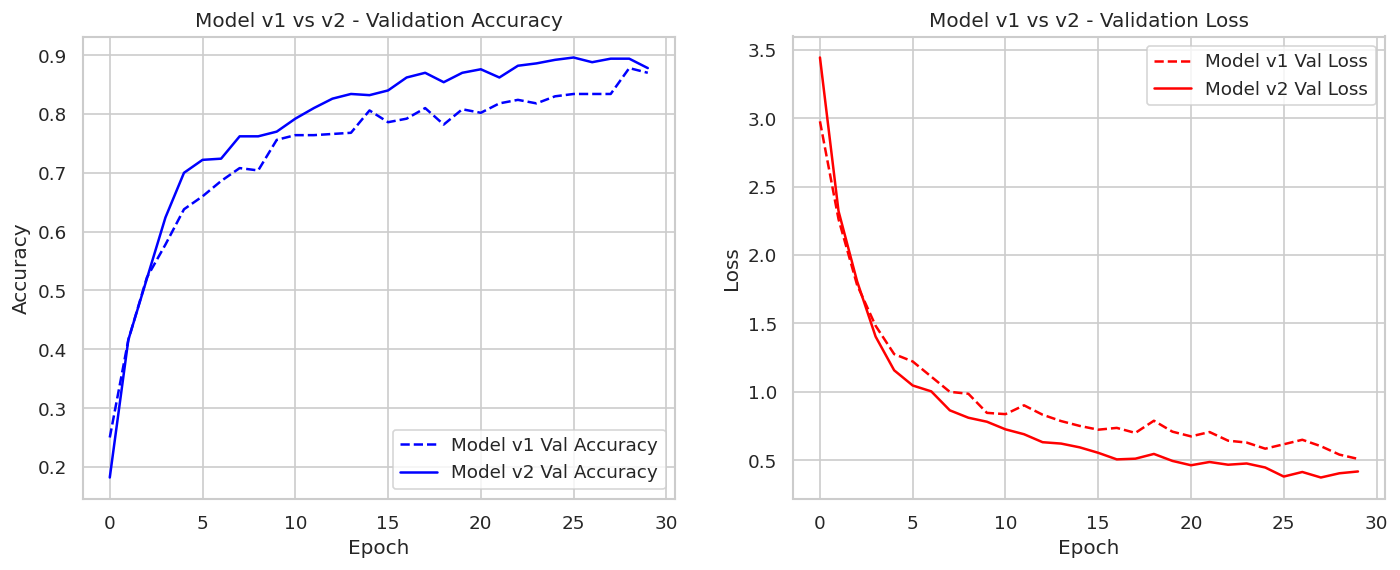

--- Test Seti Performansı ---
Model v1 (Orijinal):   Test Loss: 0.4151, Test Accuracy: 88.60%
Model v2 (Daha Derin): Test Loss: 0.3019, Test Accuracy: 92.20%


In [10]:
# === SONUÇLARI KARŞILAŞTIRMA (TAM VE DÜZELTİLMİŞ HALİ) ===

# Model v1'in sonuçları (orijinal `history` objesinden)
acc_v1 = history.history['val_accuracy']
loss_v1 = history.history['val_loss']

# Model v2'nin sonuçları (yeni `history_v2` objesinden)
acc_v2 = history_v2.history['val_accuracy']
loss_v2 = history_v2.history['val_loss']

# En kısa olan epoch sayısını baz alarak grafik çizelim (EarlyStopping farklı yerlerde durmuş olabilir)
min_epochs = min(len(acc_v1), len(acc_v2))
epochs_range = range(min_epochs)

plt.figure(figsize=(14, 5))

# Doğruluk (Accuracy) Karşılaştırması
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_v1[:min_epochs], label='Model v1 Val Accuracy', color='blue', linestyle='--')
plt.plot(epochs_range, acc_v2[:min_epochs], label='Model v2 Val Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Model v1 vs v2 - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Kayıp (Loss) Karşılaştırması
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_v1[:min_epochs], label='Model v1 Val Loss', color='red', linestyle='--')
plt.plot(epochs_range, loss_v2[:min_epochs], label='Model v2 Val Loss', color='red')
plt.legend(loc='upper right')
plt.title('Model v1 vs v2 - Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# --- Test seti üzerinde nihai karşılaştırma ---
print("--- Test Seti Performansı ---")

# Model v1 için tek bir 'results' sözlüğüne alıyoruz
results_v1 = model.evaluate(test_generator, verbose=0, return_dict=True)
print(f"Model v1 (Orijinal):   Test Loss: {results_v1['loss']:.4f}, Test Accuracy: {results_v1['accuracy']*100:.2f}%")

# Model v2 için de aynısını yapıyoruz
results_v2 = model_v2.evaluate(test_generator, verbose=0, return_dict=True)
print(f"Model v2 (Daha Derin): Test Loss: {results_v2['loss']:.4f}, Test Accuracy: {results_v2['accuracy']*100:.2f}%")

## 11. En İyi Modelin (v2) Detaylı Değerlendirilmesi

Test seti üzerinde daha başarılı olan `model_v2`'nin performansı, sınıf bazında detaylı bir şekilde incelenir.
* **`classification_report`**: Her bir kelebek türü için `precision`, `recall` ve `f1-score` metriklerini hesaplar. Bu, modelin hangi sınıfları iyi, hangilerini kötü öğrendiğini gösterir.
* **`confusion_matrix` (Karmaşıklık Matrisi)**: Modelin hangi sınıfları birbiriyle karıştırdığını görselleştiren bir matristir. Örneğin, "Model A türünü sürekli B türü ile karıştırıyor" gibi çıkarımlar yapmamızı sağlar.

Geliştirilmiş Model (v2) - Test Seti Performansı:

Sınıflandırma Raporu (Model v2):
                           precision    recall  f1-score   support

                   ADONIS     1.0000    1.0000    1.0000         5
AFRICAN GIANT SWALLOWTAIL     0.8333    1.0000    0.9091         5
           AMERICAN SNOOT     0.7500    0.6000    0.6667         5
                    AN 88     1.0000    1.0000    1.0000         5
                  APPOLLO     0.8333    1.0000    0.9091         5
     ARCIGERA FLOWER MOTH     1.0000    0.8000    0.8889         5
                    ATALA     1.0000    1.0000    1.0000         5
               ATLAS MOTH     1.0000    1.0000    1.0000         5
 BANDED ORANGE HELICONIAN     1.0000    1.0000    1.0000         5
           BANDED PEACOCK     1.0000    1.0000    1.0000         5
        BANDED TIGER MOTH     1.0000    1.0000    1.0000         5
            BECKERS WHITE     0.8000    0.8000    0.8000         5
  BIRD CHERRY ERMINE MOTH     1.0000    1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


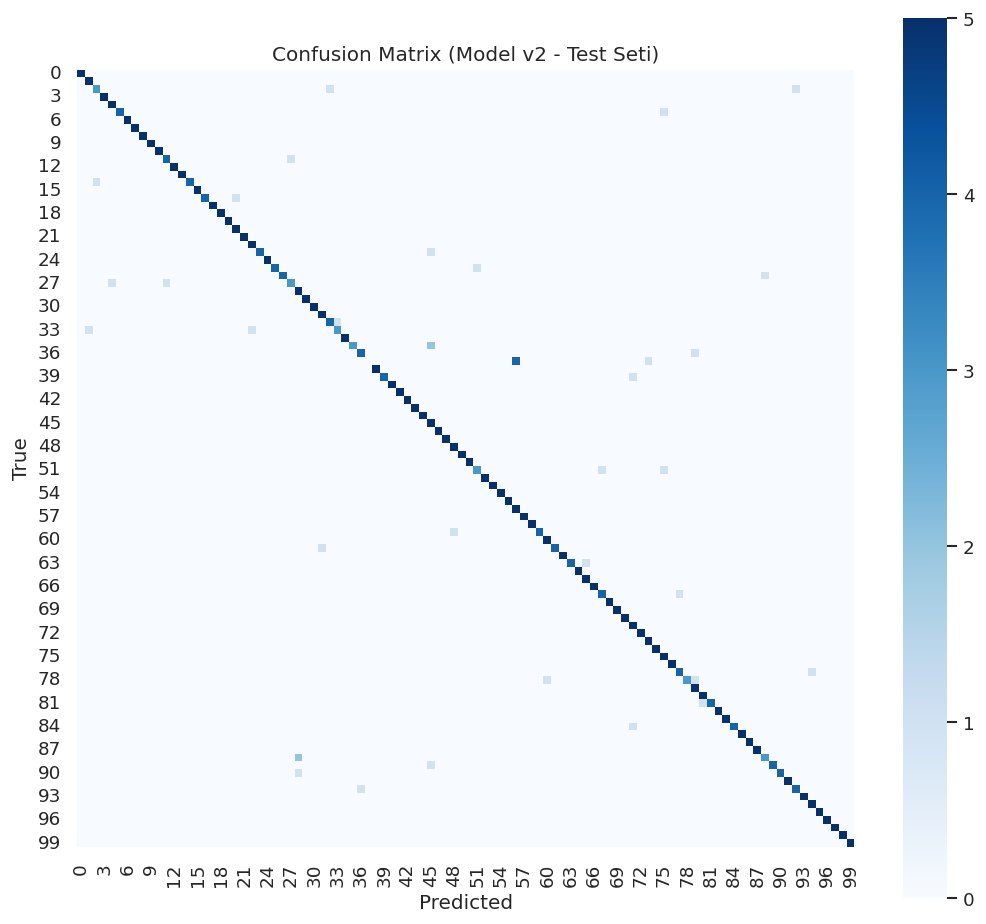

In [11]:
# === GELİŞTİRİLMİŞ MODEL (v2) İÇİN DETAYLI DEĞERLENDİRME ===
from sklearn.metrics import classification_report, confusion_matrix

print("Geliştirilmiş Model (v2) - Test Seti Performansı:")

# Tahminleri model_v2 üzerinden alıyoruz
probs_v2 = model_v2.predict(test_generator, verbose=0)
preds_v2 = np.argmax(probs_v2, axis=1)
true_labels = test_generator.classes # Gerçek etiketler aynı kalır
class_labels = list(test_generator.class_indices.keys())

print("\nSınıflandırma Raporu (Model v2):")
print(classification_report(true_labels, preds_v2, target_names=class_labels, digits=4))

cm_v2 = confusion_matrix(true_labels, preds_v2)
plt.figure(figsize=(9,8))
sns.heatmap(cm_v2, cmap="Blues", square=True, cbar=True)
plt.title('Confusion Matrix (Model v2 - Test Seti)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

## 12. Model Yorumlanabilirliği: Grad-CAM Kurulumu

Modelimizin bir "kara kutu" (black box) gibi çalışmasını istemeyiz. **Grad-CAM (Gradient-weighted Class Activation Mapping)**, modelin bir tahminde bulunurken görüntünün hangi bölgelerine "odaklandığını" veya "önem verdiğini" gösteren bir tekniktir.
* Bu hücrede, Grad-CAM hesaplaması için gerekli altyapı kurulur.
* `model_v2`'nin son evrişim katmanının (`conv4_v2`) çıktılarını ve modelin nihai tahminlerini aynı anda verebilen yeni bir `grad_model_v2` oluşturulur.
* Görüntü yükleme ve CAM hesaplama işlemleri için yardımcı fonksiyonlar tanımlanır.

In [12]:
# ===  - Model v2 için Temel Grad-CAM ===
import os, cv2, numpy as np, tensorflow as tf, matplotlib.pyplot as plt

# 1. model_v2 için yeni bir Grad-CAM modeli oluştur
# Model v2'nin son konvolüsyon katmanını buluyoruz (adını "conv4_v2" olarak belirlemiştik)
try:
    last_conv_v2 = model_v2.get_layer("conv4_v2")
    grad_model_v2 = tf.keras.Model(
        [model_v2.inputs], [last_conv_v2.output, model_v2.output], name="grad_model_v2"
    )
    print(f"Grad-CAM için '{model_v2.name}' modeli ve '{last_conv_v2.name}' katmanı kullanılacak.")
except Exception as e:
    print(f"Hata: 'conv4_v2' katmanı bulunamadı. Lütfen model_v2 özetini kontrol edin. Detay: {e}")

# 2. Grad-CAM hesaplama fonksiyonu (model_v2 için)
# Bu fonksiyonlar daha önce tanımlanmış olsa da, bu hücreyi bağımsız çalışabilir kılmak için tekrar ekliyoruz.
def _load_tensor(rel_path, size=(IMG_WIDTH, IMG_HEIGHT)):
    p = os.path.join(DATA_DIR, rel_path)
    img = tf.keras.preprocessing.image.load_img(p, target_size=size)
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x[None, ...] / 255.0
    return x

def _compute_cam_v2(x_tensor, class_index=None):
    """Grad-CAM'i model_v2 için hesaplar."""
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model_v2(x_tensor, training=False)
        tape.watch(conv_out)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]
    
    grads = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    cam = tf.reduce_sum(weights * conv_out, axis=-1)[0]
    cam = tf.nn.relu(cam)
    cam = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) - tf.reduce_min(cam) + 1e-8)
    cam = tf.image.resize(cam[..., None], (IMG_WIDTH, IMG_HEIGHT)).numpy()[..., 0]
    top_idx = int(class_index.numpy() if hasattr(class_index, "numpy") else class_index)
    return cam, top_idx

Grad-CAM için 'butterfly_cnn_v2' modeli ve 'conv4_v2' katmanı kullanılacak.


## 13. Grad-CAM Görselleştirmesi

Bu hücrede, bir önceki adımda kurulan altyapı kullanılarak Grad-CAM ısı haritaları (heatmaps) oluşturulur ve test setinden rastgele seçilen görseller üzerine bindirilir.
* Görselleştirme fonksiyonu (`viz_cam`), orijinal görüntüyü ve modelin odaklandığı bölgeleri gösteren ısı haritası bindirilmiş halini yan yana gösterir.
* Bu çıktılar, modelin doğru tahminler yaparken gerçekten de kelebeğin kanatları, deseni gibi anlamlı bölgelere odaklanıp odaklanmadığını doğrulamamızı sağlar.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_v2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


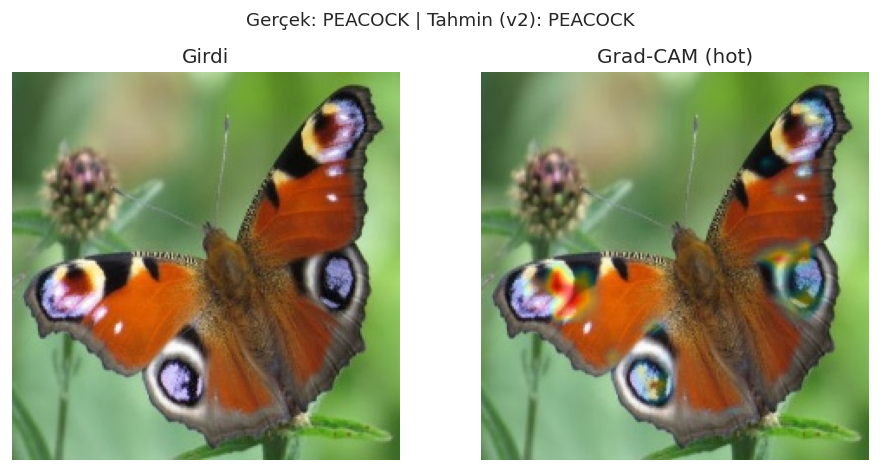

Kaydedildi: gradcam_samples_v2/cam_top_v2_12955.png


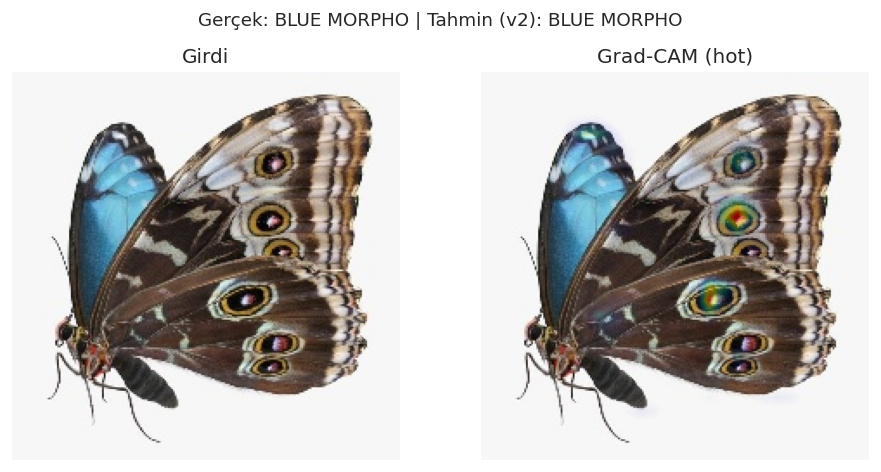

Kaydedildi: gradcam_samples_v2/cam_top_v2_12667.png


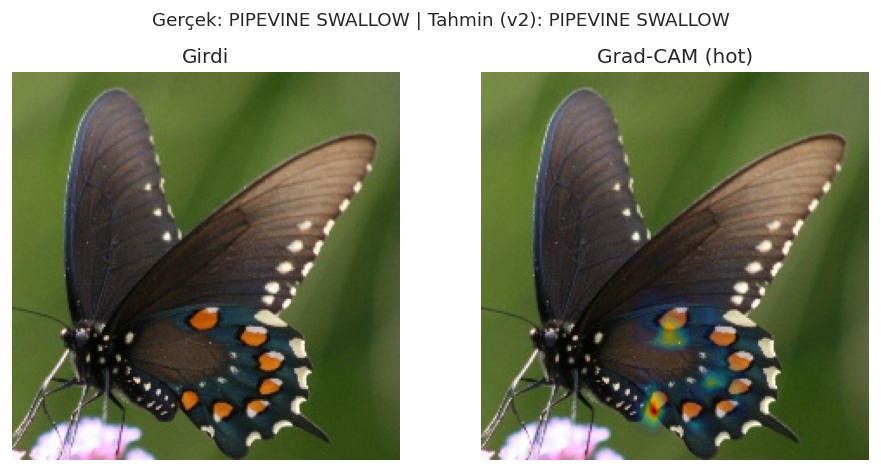

Kaydedildi: gradcam_samples_v2/cam_top_v2_12968.png


In [13]:
# === - Model v2 için Gelişmiş Grad-CAM Görselleştirmesi ===

# Model v2 çıktıları için yeni bir klasör oluşturalım
SAVE_DIR_V2 = "gradcam_samples_v2"
os.makedirs(SAVE_DIR_V2, exist_ok=True)

# Görselleştirme fonksiyonunu (viz_cam) yeniden tanımlamaya gerek yok, öncekiyle aynı.
# Eğer tanımlı değilse, buraya ekleyebilirsiniz:
def viz_cam(original_uint8, cam01, title, save_name, hot_pct=85):
    thr = np.percentile(cam01, hot_pct)
    hot = np.clip((cam01 - thr) / (1e-8 + 1 - thr), 0, 1)
    heat = (cam01 * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)[:, :, ::-1]
    alpha = (0.65 * hot)[..., None]
    overlay = (alpha * heat + (1 - alpha) * original_uint8).astype(np.uint8)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(original_uint8); plt.axis('off'); plt.title("Girdi")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis('off'); plt.title("Grad-CAM (hot)")
    plt.suptitle(title, fontsize=11); plt.tight_layout()
    plt.savefig(save_name, dpi=150, bbox_inches='tight'); plt.show()
    print("Kaydedildi:", save_name)

# Rastgele örnekler üzerinde gelişmiş görselleştirme
samples_adv_v2 = test_df.sample(n=3, random_state=42) # Farklı bir seed ile yeni örnekler
for idx, row in samples_adv_v2.iterrows():
    x = _load_tensor(row.filepaths)
    cam01, top_idx = _compute_cam_v2(x) # v2 için hesaplama fonksiyonumuzu kullanıyoruz
    original = (x[0] * 255).astype(np.uint8)
    pred_label = list(test_generator.class_indices.keys())[top_idx]
    
    title = f"Gerçek: {row.labels} | Tahmin (v2): {pred_label}"
    save_path = os.path.join(SAVE_DIR_V2, f"cam_top_v2_{idx}.png")
    viz_cam(original, cam01, title, save_name=save_path, hot_pct=85)

## 14. Gelişmiş Analiz: Hatalı Tahminlerin Grad-CAM ile İncelenmesi

Model yorumlanabilirliğinin en güçlü kullanım alanlarından biri, modelin **neden hata yaptığını** anlamaya çalışmaktır.
* Bu bölümde, `model_v2`'nin test setinde yanlış sınıflandırdığı bazı örnekler bulunur.
* Bu hatalı örnekler için iki farklı Grad-CAM analizi yapılır:
    1.  Modelin **yanlış tahmini** yaparken nereye odaklandığını gösteren ısı haritası.
    2.  Eğer **doğru sınıfı** tahmin etseydi nereye odaklanması gerektiğini gösteren ısı haritası.
* Bu karşılaştırma, modelin kafa karışıklığının nedenini (örneğin, iki türün benzer kanat desenleri) ortaya çıkarabilir.

Model v2'nin ilk 6 hatası:


class id                        filepaths                labels data set  \
12         2        test/AMERICAN SNOOT/3.jpg        AMERICAN SNOOT     test   
14         2        test/AMERICAN SNOOT/5.jpg        AMERICAN SNOOT     test   
25         5  test/ARCIGERA FLOWER MOTH/1.jpg  ARCIGERA FLOWER MOTH     test   
58        11         test/BECKERS WHITE/4.jpg         BECKERS WHITE     test   
72        14           test/BLUE MORPHO/3.jpg           BLUE MORPHO     test   
81        16      test/BROOKES BIRDWING/2.jpg      BROOKES BIRDWING     test   

            pred_label  correct  
12   TROPICAL LEAFWING    False  
14         COPPER TAIL    False  
25     POLYPHEMUS MOTH    False  
58  CLODIUS PARNASSIAN    False  
72      AMERICAN SNOOT    False  
81     CAIRNS BIRDWING    False

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_v2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


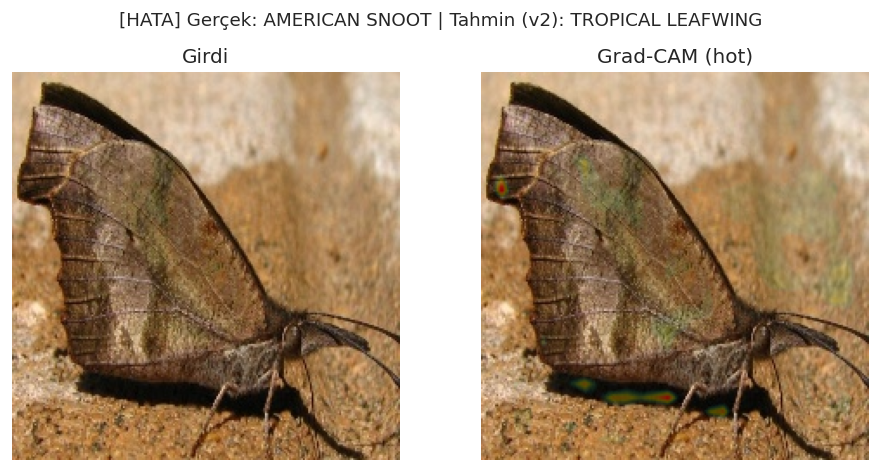

Kaydedildi: gradcam_errors_v2/err_12_pred_v2.png


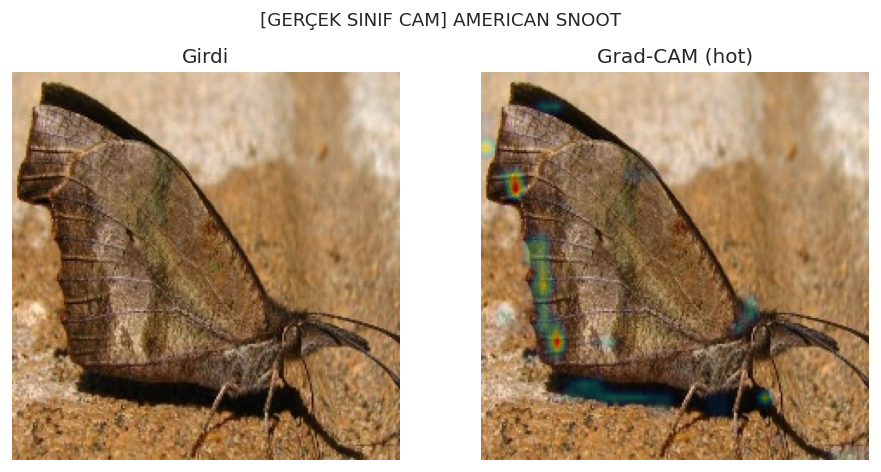

Kaydedildi: gradcam_errors_v2/err_12_true_v2.png


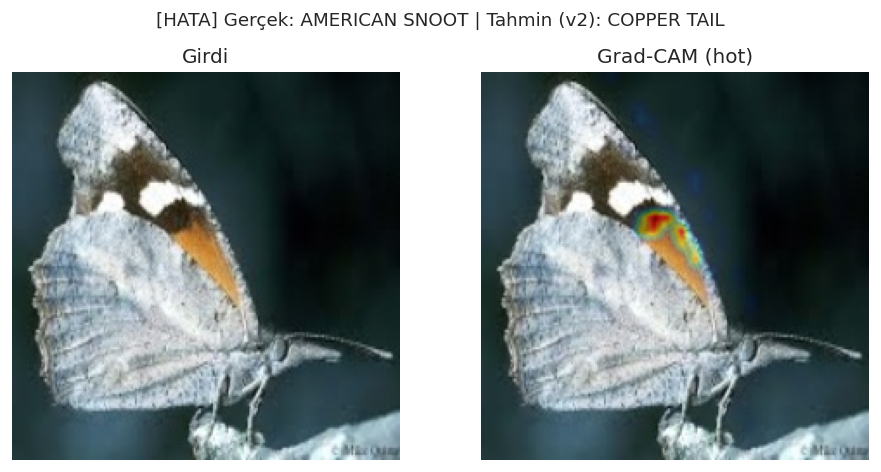

Kaydedildi: gradcam_errors_v2/err_14_pred_v2.png


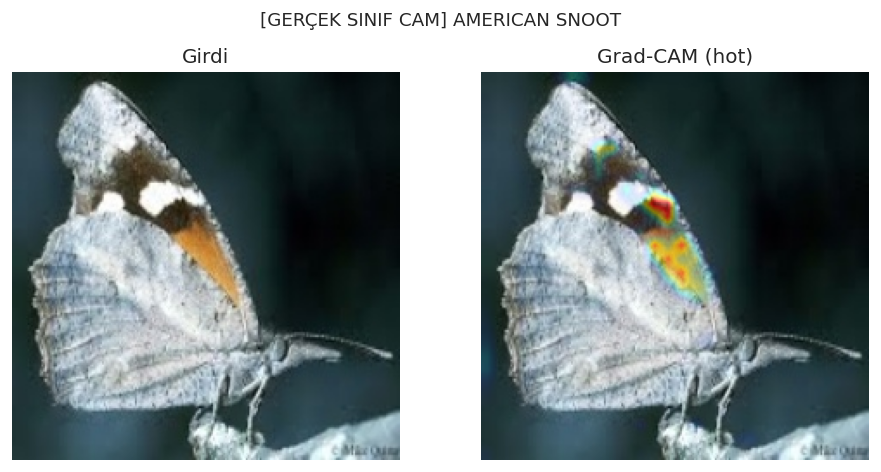

Kaydedildi: gradcam_errors_v2/err_14_true_v2.png


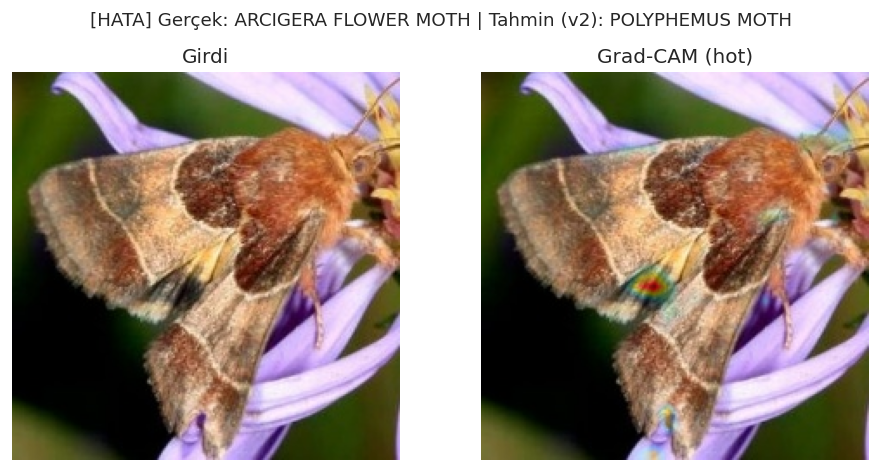

Kaydedildi: gradcam_errors_v2/err_25_pred_v2.png


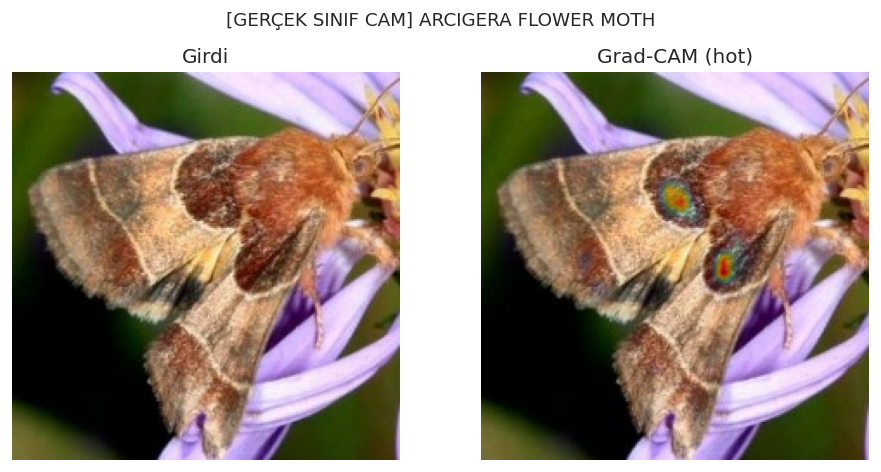

Kaydedildi: gradcam_errors_v2/err_25_true_v2.png


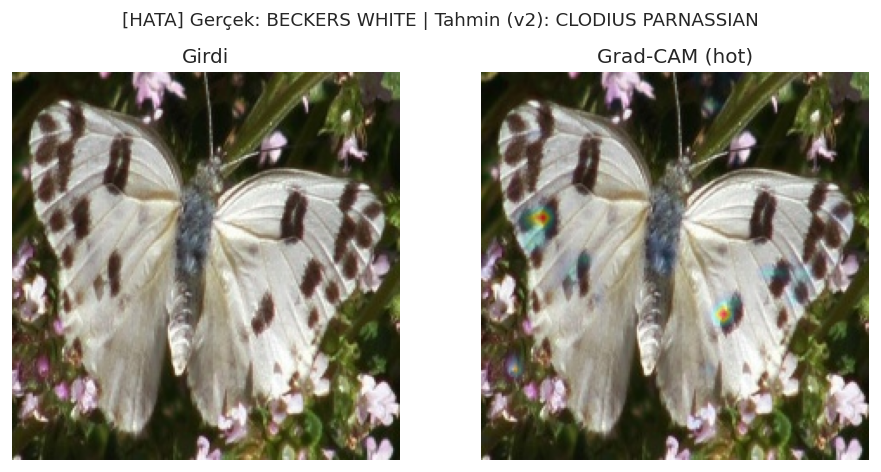

Kaydedildi: gradcam_errors_v2/err_58_pred_v2.png


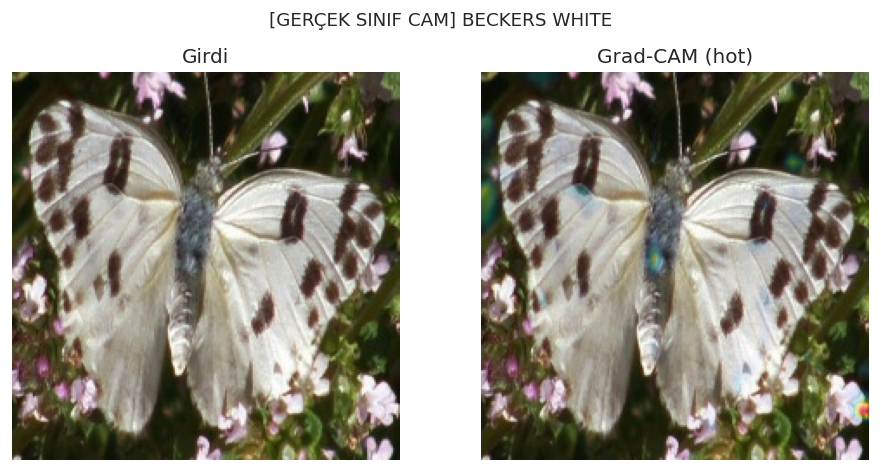

Kaydedildi: gradcam_errors_v2/err_58_true_v2.png


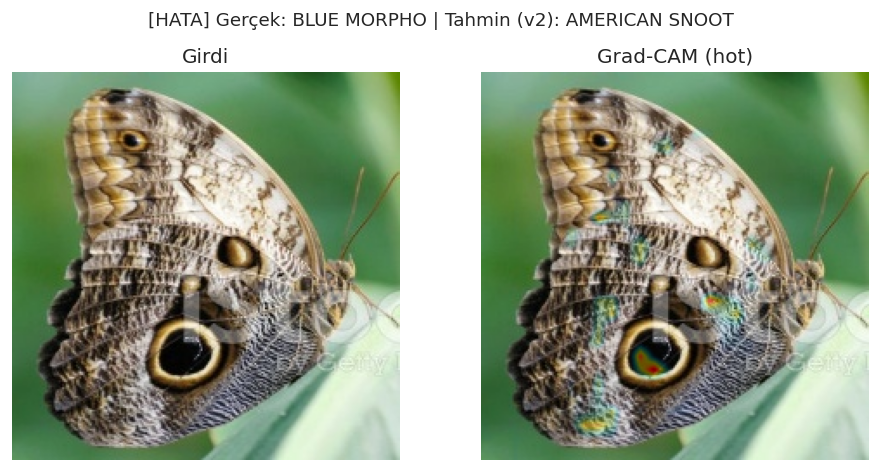

Kaydedildi: gradcam_errors_v2/err_72_pred_v2.png


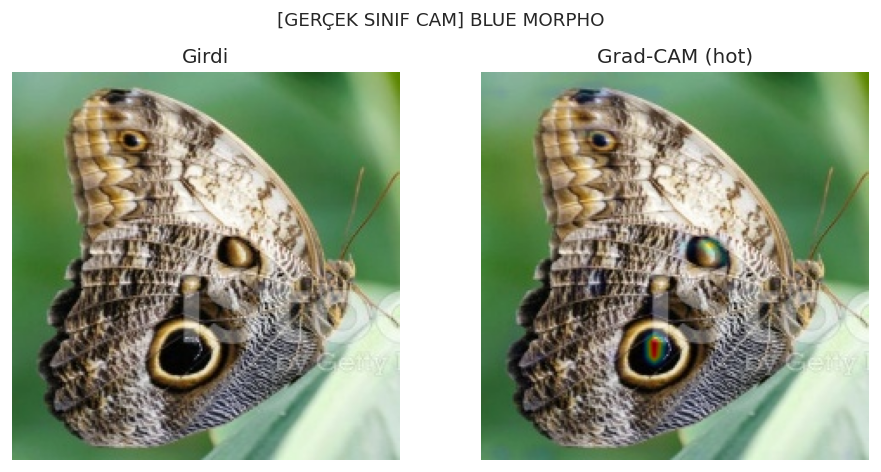

Kaydedildi: gradcam_errors_v2/err_72_true_v2.png


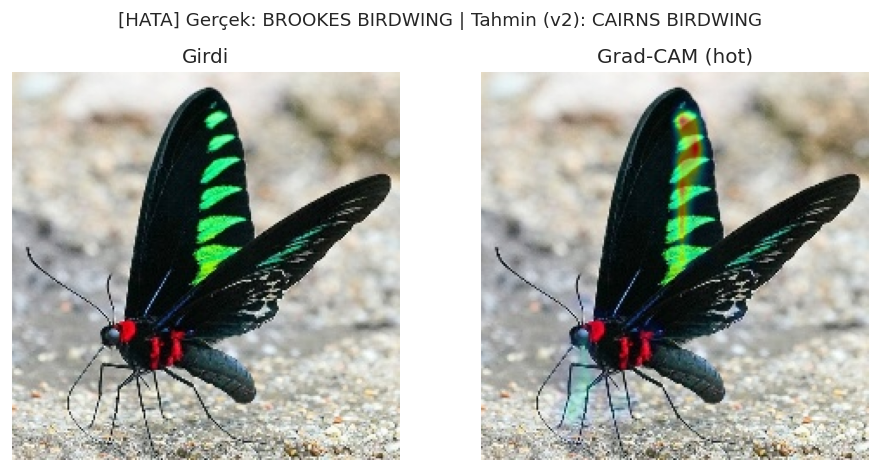

Kaydedildi: gradcam_errors_v2/err_81_pred_v2.png


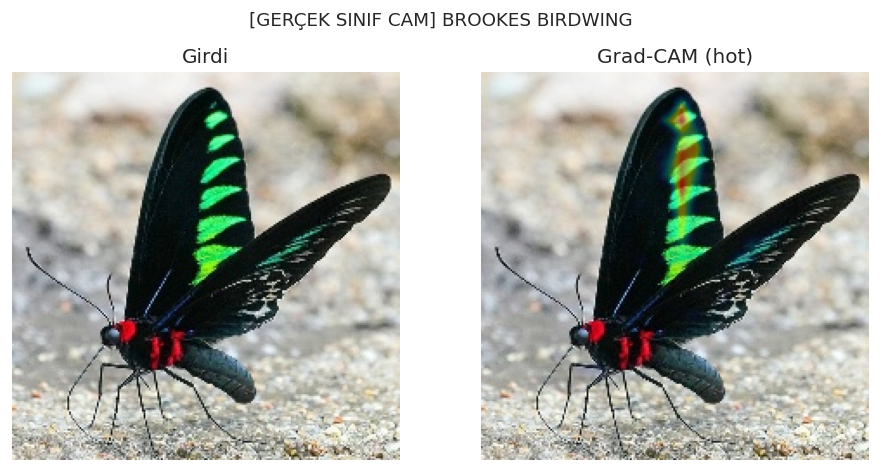

Kaydedildi: gradcam_errors_v2/err_81_true_v2.png


In [14]:
# ===  - Model v2 için Hatalı Tahmin Analizi ===

# Model v2'nin hatalı tahminleri için yeni bir klasör
ERR_DIR_V2 = "gradcam_errors_v2"
os.makedirs(ERR_DIR_V2, exist_ok=True)

# 1. Model v2'nin hatalarını içeren bir dataframe oluştur
# (Bu değişkenleri bir önceki değerlendirme hücresinde zaten oluşturmuştuk: preds_v2)
eval_df_v2 = test_df.reset_index(drop=True).copy()
inv_map = {v:k for k,v in test_generator.class_indices.items()}
eval_df_v2["pred_label"] = [inv_map[i] for i in preds_v2] # preds_v2'yi kullanıyoruz
eval_df_v2["correct"] = (eval_df_v2["labels"] == eval_df_v2["pred_label"])
errors_v2 = eval_df_v2[~eval_df_v2["correct"]].head(6)

print(f"Model v2'nin ilk 6 hatası:")
display(errors_v2)

# 2. Belirli bir sınıf için CAM hesaplayan yardımcı fonksiyon (v2 için)
def _compute_cam_for_v2(x_tensor, class_index):
    """Belirtilen class_index için Grad-CAM'i model_v2 ile hesaplar."""
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model_v2(x_tensor, training=False)
        tape.watch(conv_out)
        loss = preds[:, class_index]
    
    grads = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    cam = tf.reduce_sum(weights * conv_out, axis=-1)[0]
    cam = tf.nn.relu(cam)
    cam = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) - tf.reduce_min(cam) + 1e-8)
    cam = tf.image.resize(cam[..., None], (IMG_WIDTH, IMG_HEIGHT)).numpy()[..., 0]
    return cam

# 3. Hatalı tahminleri analiz et
for i, row in errors_v2.iterrows():
    x = _load_tensor(row.filepaths)
    original = (x[0] * 255).astype(np.uint8)
    
    # a) Modelin yaptığı YANLIŞ tahmin için CAM
    pred_idx = test_generator.class_indices[row["pred_label"]]
    cam_pred = _compute_cam_for_v2(x, pred_idx)
    title_pred = f"[HATA] Gerçek: {row.labels} | Tahmin (v2): {row.pred_label}"
    save_path_pred = os.path.join(ERR_DIR_V2, f"err_{i}_pred_v2.png")
    viz_cam(original, cam_pred, title_pred, save_path_pred)

    # b) Aslında olması gereken DOĞRU sınıf için CAM
    # (Model doğru sınıfa odaklansaydı nereye bakardı?)
    true_idx = test_generator.class_indices[row["labels"]]
    cam_true = _compute_cam_for_v2(x, true_idx)
    title_true = f"[GERÇEK SINIF CAM] {row.labels}"
    save_path_true = os.path.join(ERR_DIR_V2, f"err_{i}_true_v2.png")
    viz_cam(original, cam_true, title_true, save_path_true)

## 15. Nihai Modelin Kaydedilmesi

Projenin son adımı olarak, en iyi performansı gösteren eğitilmiş model (`model_v2`), ileride tekrar kullanmak veya bir uygulamaya entegre etmek üzere `.keras` formatında diske kaydedilir. Bu, saatler sürebilecek eğitim sürecini tekrar yapma zorunluluğunu ortadan kaldırır.

In [15]:
# Nihai ve en iyi model olarak v2'yi kaydediyoruz
FINAL_V2_PATH = "butterfly_final_model.keras"
model_v2.save(FINAL_V2_PATH)

print(f"En iyi model (v2) başarıyla kaydedildi: {FINAL_V2_PATH}")

En iyi model (v2) başarıyla kaydedildi: butterfly_final_model.keras
